# Imports

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.compat.v1.saved_model import load, tag_constants

from PIL import Image

%matplotlib inline

# Constants

In [2]:
SAMPLE_IMAGE = 'Image_Samples/1.png'
ALPHABETS = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F'}
RIGHT_ANS = ['A','C','D','B','B','A','D','E','A','C','D','B','C','A','E','B','C','D','E','A']

# Helper Functions

In [3]:
def get_all_childs_of_parent(parent, hierarchy):
    '''
    This function will return all the child of that contour
    Parameters:
    parent : Int value
    hierarchy: contours hierarchy
    '''
    # Initialize
    hier_len = hierarchy.shape[1] #Total contours
    child_contours = {} #Empty Dict
    
    for x in range(hier_len):
        # To loop through whole hierarchy
        next_contour, pre_contour, first_child, parent_contour = hierarchy[0][x]
        
        # If desired parent found, so append it all childs
        if parent == parent_contour:
            child_contours[x] = hierarchy[0][x]
        
    # return all the found contours
    return child_contours

def extract_desired_contours(contours_dict, contours):
    '''
    This function will extract only desired contours
    Parameters:
    contours_dict : Desired contours as Dict
    contours: All contours
    ''' 
    desired_contours = []
    
    for i in range(len(contours)):
        for key,value in contours_dict.items():
            next_contour, pre_contour, first_child, parent = value
            if i == first_child:
                desired_contours.append(contours[i])
                
    return desired_contours


def draw_rectangle_on_img_contours_and_croppping_them(contours, image, arr_contours):
    '''
    This function will draw rectangles on image
    Parameters:
    contours : array
    image: image
    arr_contours: array in which cropped contours to be saved
    '''
    total_contours = len(contours)
    rect_color = (255,0,0)
    rect_stroke_width = 2
    
    new_img = image.copy()
    
    for i in range(total_contours):
        cnt = contours[i]
        x,y,w,h = cv2.boundingRect(cnt)
        image = cv2.rectangle(image, (x,y), (x+w,y+h), rect_color, rect_stroke_width)
        
        # Step 5: Cropping individual contours and saving them in array
        cropping_rectangles_and_saving_them(x,y,x+w,y+h,new_img,i,arr_contours)
        
    # To visualize all contours on image
    #plt.imshow(image)
    #plt.show()
      

def cropping_rectangles_and_saving_them(left,upper,right,lower, image_name, cropped_image_name, arr_contours):
    '''
    This function will crop all the bounding rectangles from an image
    Parameters:
    left=x,upper=y,right=x+w,lower=y+h
    image_name: original image
    cropped_image_name: individual cropped images name
    '''
    # Opens image using PIL
    im = Image.fromarray(image_name)
    
    # Crop image from original image
    box = (left,upper,right,lower)
    cropped_image = im.crop(box)
    
    # Appending cropped contours
    arr_contours.append(cropped_image)
    
    
def resizing_cropped_img_to_20_by_20(arr_cropped_images):
    '''
    This function will resize all the cropped images to 20x20
    Parameters:
    arr_cropped_images: arr containing all cropped numbers
    '''
    new_Arr = []
    
    for i in range(len(arr_cropped_images)):
        # Step:6 Resize img to 20 by 20
        new_Arr.append(arr_cropped_images[i].resize((20,20)))
        
    return new_Arr
    
    
def add_borders_to_img(arr_20x20_imgs):
    '''
    This function will resize all the cropped images to 28x28
    Parameters:
    arr_20x20_imgs: arr containing all 20x20 images
    '''
    new_Arr = []
    
    for i in range(len(arr_20x20_imgs)):
        old_size = arr_20x20_imgs[i].size
        new_size = (28,28)
        
        img_28x28 = Image.new('RGB',new_size, color=(255,255,255))
        img_28x28.paste(arr_20x20_imgs[i],((new_size[0]-old_size[0])//2,(new_size[1]-old_size[1])//2))
        new_Arr.append(img_28x28)
        
    return new_Arr

def recognize_and_evaluate_mcqs(image):
    '''
    This function will regonize recognize and evaluate mcqs
    Parameters:
    image: Original image on plain background paper
    '''
    
    # ------------------------------------------
    # STEP 1: READ IMAGE
    # ------------------------------------------
    img = cv2.imread(image)
    
    # ------------------------------------------
    # STEP 2: CONVERT RGB -> GRAYSCALE -> BINARY
    # ------------------------------------------
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)

    # ------------------------------------------
    # STEP 3: FIND IMAGE CONTOURS
    # ------------------------------------------
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

    # --------------------------------------------------------------------
    # STEP 4: REMOVE UN-NECESSARY CHILDS 
    # --------------------------------------------------------------------
    contours_to_keep_dict = get_all_childs_of_parent(2,hierarchy)
    contours = extract_desired_contours(contours_to_keep_dict, contours)

    # ------------------------------------------------
    # STEP 5: DRAW RECTANGLE ON CONTOURS & CROP THEM
    # ------------------------------------------------
    ARR_CROPPED_NR = []
    draw_rectangle_on_img_contours_and_croppping_them(contours,thresh.copy(),ARR_CROPPED_NR)
    
    # ------------------------------------------------
    # STEP 6: CONVERT CROPPED DIGITS TO 20X20
    # ------------------------------------------------
    arr_img_20x20 = resizing_cropped_img_to_20_by_20(ARR_CROPPED_NR)
    
    # ------------------------------------------------
    # STEP 7: CONVERT 20x20 TO 28X28 AND REVERSE IT
    # ------------------------------------------------
    arr_img_28x28 = add_borders_to_img(arr_img_20x20)
    arr_img_28x28.reverse()
    
    # ------------------------------------------------
    # STEP 8: CONVERT 28x28 TO FLAT ARRAY
    #         AND ELIMINATE MCQ NR
    # ------------------------------------------------
    x_test = []

    for i in range(len(arr_img_28x28)):
        if i in range(10,20,1): #10-19
            bw = arr_img_28x28[i].convert('L')
            img_array = np.invert(bw)
            test_img = img_array.ravel()
            x_test.append(test_img)
        elif i in range(30,40,1): #30-39
            bw = arr_img_28x28[i].convert('L')
            img_array = np.invert(bw)
            test_img = img_array.ravel()
            x_test.append(test_img)
     
    # ------------------------------------------------
    # STEP 9: LOAD MODEL AND CREATE SESSION
    # ------------------------------------------------
    # Create a graph obj placeholder
    graph = tf.Graph()

    # Creating a sess obj and linking session and the graph
    sess = tf.compat.v1.Session(graph=graph)
    
    # Loading the Model
    load(sess=sess, tags=[tag_constants.SERVING], export_dir='SavedModel')
    
    # ------------------------------------------------
    # STEP 9: MAKING PREDICTIONS
    # ------------------------------------------------
    # Return the `Tensor` with the given `name` and index=0 result
    X = graph.get_tensor_by_name('X:0')

    # Get hold of the tensor that will hold the predictions from the graph. Store these under y_pred
    y_pred = graph.get_tensor_by_name('accuracy_calc/prediction:0')

    # fetches = y_pred(the output we are after)
    prediction = sess.run(fetches=y_pred, feed_dict={X: x_test})
    
    # ------------------------------------------------
    # STEP 10: DECODING PREDICTIONS
    # ------------------------------------------------
    arr_predicted_alphabets = []
    
    for i in range(len(prediction)):
        for key,value in ALPHABETS.items():
            if prediction[i] == key:
                arr_predicted_alphabets.append(value)
                
    return arr_predicted_alphabets

# Image Processing

### User 1

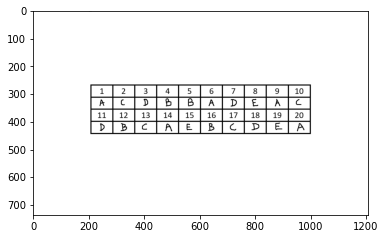

In [4]:
img = cv2.imread(SAMPLE_IMAGE)
plt.imshow(img)
plt.show()

In [5]:
predictions = recognize_and_evaluate_mcqs(SAMPLE_IMAGE)
predictions

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from SavedModel/variables/variables


['A',
 'C',
 'D',
 'B',
 'B',
 'A',
 'D',
 'E',
 'A',
 'C',
 'D',
 'B',
 'C',
 'A',
 'E',
 'B',
 'C',
 'D',
 'E',
 'A']

In [6]:
type(predictions)

list

In [7]:
score = 0
for i in range(len(predictions)):
    if predictions[i] == RIGHT_ANS[i]:
        score = score + 1
    

In [8]:
score

20